In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data parsing

In [122]:
data = pd.read_csv('data/4calib/03/val.030.001-023.14h00m24/val.030.001-023.tbl.csv')

In [123]:
colnames = data.columns
colnames = colnames[0].split('\t')
colnames = [s.lstrip() for s in colnames]
colnames

['index',
 'time',
 'gps_gm_x',
 'gps_gm_y',
 'vehicle_speed',
 'can_steering',
 'vis_wu',
 'wheel_angle_vis']

In [124]:
data.columns = ['data']

In [125]:
extracted_data_journal = []
extracted_data = []
new_journal = True

for i in range(data.shape[0]):
    if new_journal:
        extracted_data = np.fromstring(data['data'][i], dtype=np.double, sep='\t')
        new_journal = False
    else:
        if data['data'][i][0] == 'i':
            extracted_data_journal.append(extracted_data)
            extracted_data = []
            new_journal = True
            continue
            
        new_reading = np.fromstring(data['data'][i], dtype=np.double, sep='\t')   
        extracted_data = np.vstack((extracted_data, new_reading))

extracted_data.shape
len(extracted_data_journal)

21

### Apply Mercator transform and plot data

In [126]:
from mercator import Mercator

In [127]:
total_data = np.vstack(extracted_data_journal)[23:]
total_coords = total_data[:, 2:4]
total_coords = np.array(Mercator(total_coords))

X = np.array(total_coords[0])
Y = np.array(total_coords[1])

-0.148132


(-5127238.422673952,
 17452320.295216568,
 -3863665.7124811886,
 166708.95652313175)

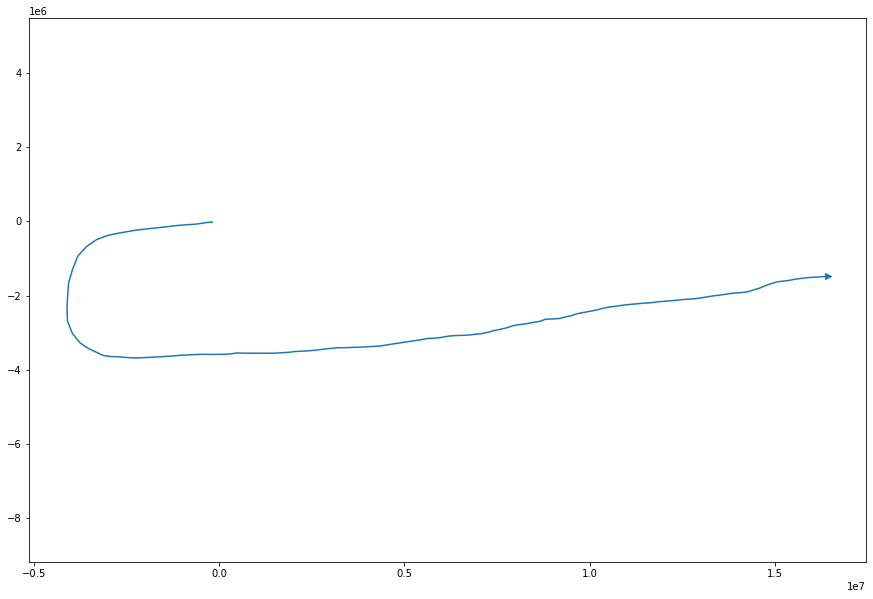

In [143]:
plt.figure(figsize=(15,10))
plt.plot(X, Y)
plt.scatter(X[-1], Y[-1], marker=">")
plt.axis('equal')

### Curvature estimation

In [256]:
from scipy.interpolate import UnivariateSpline

In [295]:
def curvature_splines(x, y):
    t = np.arange(x.shape[0])
#     std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4)
    fy = UnivariateSpline(t, y, k=4)

    dx = fx.derivative(1)(t)
    d2x = fx.derivative(2)(t)
    dy = fy.derivative(1)(t)
    d2y = fy.derivative(2)(t)
    
    curvature = (dx * d2y - dy * d2x) / np.power(dx ** 2 + dy ** 2, 1.5)
    return curvature

In [296]:
curvature = curvature_splines(X, Y)

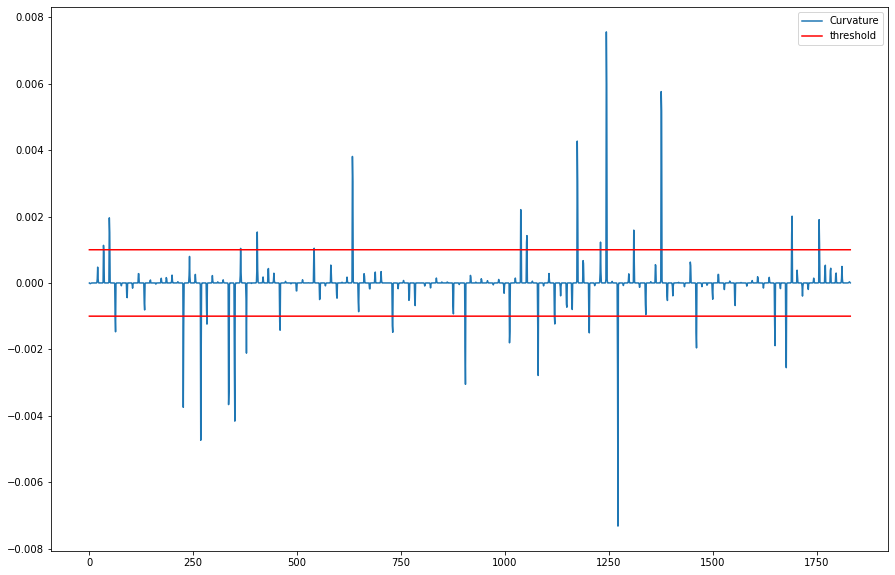

In [318]:
plt.figure(figsize=(15,10))
plt.plot(curvature, label='Curvature')
plt.plot([0.001] * len(curvature),color='red', label='threshold')
plt.plot([-0.001] * len(curvature), color='red')
plt.legend()

In [319]:
outliers = np.abs(curvature) > 0.001
outliers_indexes = np.argwhere(np.abs(curvature) > 0.002).squeeze()
sum(outliers)

58

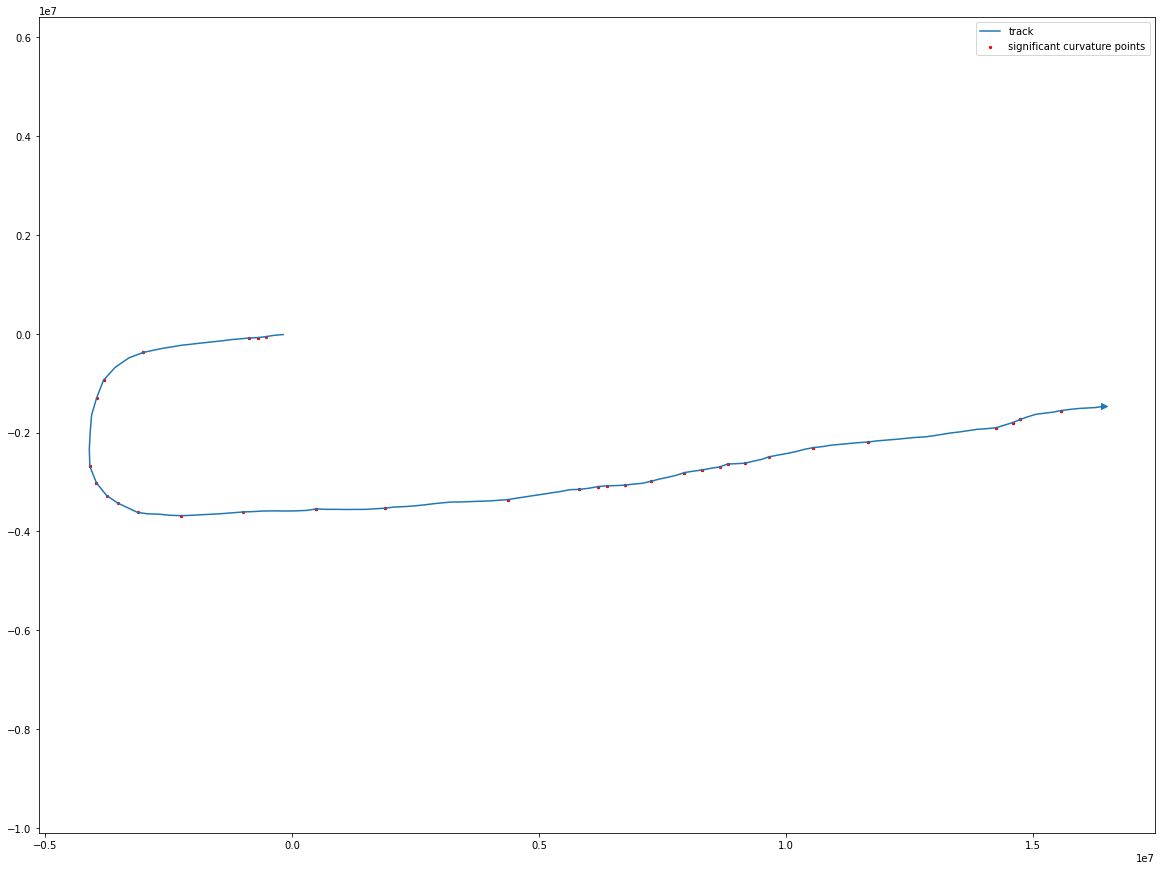

In [320]:
plt.figure(figsize=(20,15))
plt.plot(X, Y, label='track')
plt.scatter(X[outliers], Y[outliers],s=5, color='red', label='significant curvature points')
plt.scatter(X[-1], Y[-1], marker=">")
plt.axis('equal')
plt.legend()

(5926466.640374763, 7497275.943276171, -3137024.227133395, -2932172.8878155667)

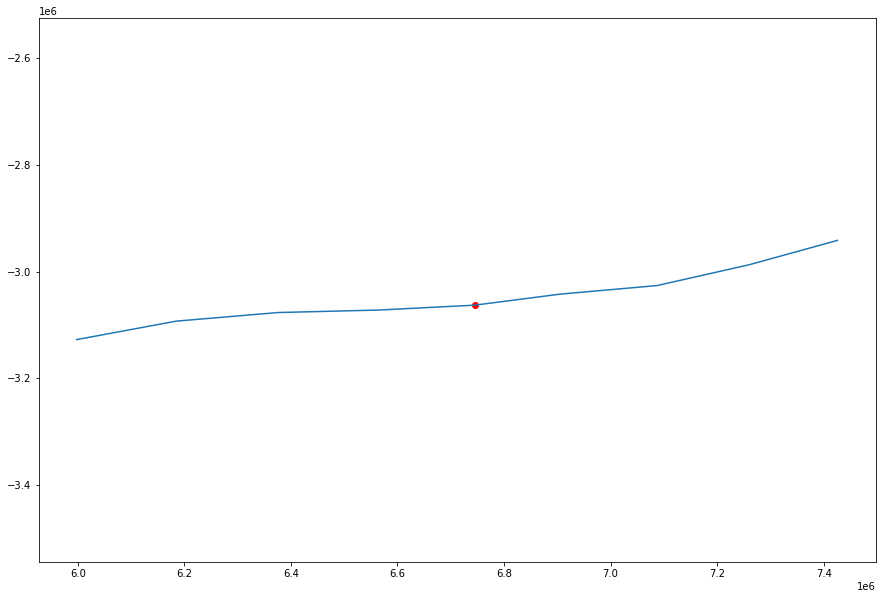

In [304]:
### choose example oulier and take a closer look
i = 13
plt.figure(figsize=(15,10))
plt.plot(X[outliers_indexes[i]-50:outliers_indexes[i]+50], Y[outliers_indexes[i]-50:outliers_indexes[i]+50])
plt.scatter(X[outliers_indexes[i]], Y[outliers_indexes[i]], color='red')

plt.axis('equal')